## Movie Review Classification - Neural Network
Task:

Write a neural network to classify movie reviews in good or bad.

Assume the dataset to be clean and ready for usage.

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

In [14]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

movie_review_data = keras.datasets.imdb

(X_train, y_train_label), (X_test, y_test_label) = movie_review_data.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

word_index = movie_review_data.get_word_index()
word_index = {k:(v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

id_to_word = {value: key for key, value in word_index.items()}

review_lengths = [len(review) for review in X_train]

print(review_lengths[0:20])

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177]


Here we have a problem. The words per review is vastly different. If we plan to use the reviews as an input
for our neural network, then we need them all to have the same shape. In order to safe some time, we will remove 
the top 10% (roughly) longest reviews based on the training set and add a padding for the remaining reviews to force that threshold length.

In [15]:
print(sum(map(lambda x : x>450, review_lengths))/len(review_lengths))

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                    value=word_index["<PAD>"],
                                                    padding="post",
                                                    maxlen=450)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_index["<PAD>"],
                                                    padding="post",
                                                    maxlen=450)

X_val = X_train[:10000]
X_train = X_train[10000:]

y_val = y_train_label[:10000]
y_train = y_train_label[10000:]

def decode_movie_reviw(text):
    return (' '.join([id_to_word.get(i, "?") for word in text]))

0.10816


In [16]:
def neural_network(epochs):
    neural_network = keras.Sequential()
    neural_network.add(keras.layers.Embedding(10000, 16))  # Input
    neural_network.add(keras.layers.GlobalAveragePooling1D())
    neural_network.add(keras.layers.Dense(32, activation="relu"))
    neural_network.add(keras.layers.Dense(1, activation="sigmoid"))  # Output

    neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    fit_result = neural_network.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        batch_size=150,
                        verbose=False)
    print("Training finished!")
    test_loss, test_acc = neural_network.evaluate(X_test, y_test_label)
    neural_network_list.append(neural_network)
    testing_acc_list.append(test_acc)
    fit_result_list.append(fit_result)

In [17]:
testing_acc_list = []
neural_network_list = []
fit_result_list = []
epoch_max = 15
for epoch in range(epoch_max):
    neural_network(epoch)

Training finished!
25000/25000 [==============================] - 1s 23us/sample - loss: 0.6932 - accuracy: 0.5000
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.6783 - accuracy: 0.7241
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.5990 - accuracy: 0.7716
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.4894 - accuracy: 0.8152
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.3918 - accuracy: 0.8563
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.3417 - accuracy: 0.8697
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.3218 - accuracy: 0.8738
Training finished!
25000/25000 [==============================] - 1s 21us/sample - loss: 0.3084 - accuracy: 0.8777
Training finished!
25000/25000 [==============================] - 1s 23us/sample

Classifictiation Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     12500
           1       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Confusion Matrix:

[[10988  1512]
 [ 1403 11097]]


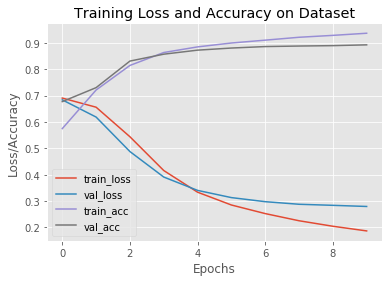

In [18]:
max_test_acc_index = testing_acc_list.index(max(testing_acc_list))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, max_test_acc_index), fit_result_list[max_test_acc_index].history["loss"], label="train_loss")
plt.plot(np.arange(0, max_test_acc_index), fit_result_list[max_test_acc_index].history["val_loss"], label="val_loss")
plt.plot(np.arange(0, max_test_acc_index), fit_result_list[max_test_acc_index].history["accuracy"], label="train_acc")
plt.plot(np.arange(0, max_test_acc_index), fit_result_list[max_test_acc_index].history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
figname = 'nn_epoch_test.png'
plt.savefig(figname)

y_predicted_proba = neural_network_list[max_test_acc_index].predict(X_test)
y_predicted = [round(x[0]) for x in y_predicted_proba]

print("Classifictiation Report:\n")
print(classification_report(y_test_label, y_predicted))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test_label, y_predicted))